In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 나눔 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

from matplotlib import font_manager, rc

# 한글 폰트 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [ ]:
import pandas as pd
df = pd.read_excel('/content/drive/MyDrive/KOPIS/블루스퀘어/트레이닝_데이터(라벨인코딩).xlsx')
test_df = pd.read_excel('/content/drive/MyDrive/KOPIS/블루스퀘어/테스트_데이터(라벨인코딩).xlsx')


In [ ]:
df

,전송사업자코드,예매/취소방식코드,결제수단코드,할인금액,할인종류코드,장당금액,성별,판매좌석수,예매후남은일자,취소여부,연도,월,일,주말여부,공휴일여부,노인,청년,성인,좌석등급
0,1,0,1,0,1,161500,2,1309,33,0,2023,10,1,1,0,0,0,1,3
1,1,0,1,0,1,161500,2,1309,33,0,2023,10,1,1,0,0,0,1,3
2,1,0,1,0,1,161500,1,1309,33,0,2023,10,1,1,0,0,0,1,3
3,1,0,1,0,1,161500,2,1309,32,1,2023,10,1,1,0,0,0,1,3
4,1,0,1,0,1,161500,1,1309,33,1,2023,10,1,1,0,0,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284595,1,1,1,0,1,76000,2,1309,0,0,2023,8,31,0,0,0,0,1,0
284596,1,1,1,0,1,76000,2,1309,0,0,2023,8,31,0,0,0,0,1,0
284597,1,1,1,0,1,80000,1,1309,0,0,2023,8,31,0,0,0,0,1,0
284598,1,1,1,0,1,133000,1,1309,0,0,2023,8,31,0,0,0,1,0,1


## 1. 앙상블 (랜포 + xgboost + LGB)

### 최종 하이퍼파라미터 설정

rf_best_params = {
    'bootstrap': True,
    'max_depth': None,
    'max_features': 'log2',
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 100,
    'class_weight': {0: 3.0, 1: 1.0},  # 클래스 0에 더 높은 가중치 부여
    'random_state': 42
}


lgbm_best_params = {
    'subsample': 0.8,
    'reg_lambda': 0,
    'reg_alpha': 0.01,
    'num_leaves': 100,
    'n_estimators': 1000,
    'min_child_samples': 20,
    'max_depth': -1,
    'learning_rate': 0.2,
    'colsample_bytree': 0.9,
    'class_weight': {0: 1.0, 1: 3.0},  # 클래스 1에 더 높은 가중치 부여
    'random_state': 42
}

xgb_best_params = {
    'subsample': 0.8,
    'reg_lambda': 0.01,
    'reg_alpha': 1,
    'n_estimators': 1000,
    'min_child_weight': 5,
    'max_depth': 15,
    'learning_rate': 0.3,
    'gamma': 0.1,
    'colsample_bytree': 0.7,
    'scale_pos_weight': 3.0,  # 클래스 1에 더 높은 가중치 부여
    'random_state': 42
}

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
import numpy as np

# Target 변수와 Feature 변수 설정
X = df.drop(columns=['취소여부'])
y = df['취소여부']

# 데이터 분할: 80% 훈련 세트, 20% 테스트 세트로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# RandomForestClassifier 설정 (클래스 0에 가중치 부여)
rf_best_params = {
    'bootstrap': True,
    'max_depth': None,
    'max_features': 'log2',
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 100,
    'class_weight': {0: 3.0, 1: 1.0},  # 클래스 0에 더 높은 가중치 부여
    'random_state': 42
}
rf_model = RandomForestClassifier(**rf_best_params)

# LightGBMClassifier 설정 (클래스 1에 가중치 부여)
lgbm_best_params = {
    'subsample': 0.8,
    'reg_lambda': 0,
    'reg_alpha': 0.01,
    'num_leaves': 100,
    'n_estimators': 1000,
    'min_child_samples': 20,
    'max_depth': -1,
    'learning_rate': 0.2,
    'colsample_bytree': 0.9,
    'class_weight': {0: 1.0, 1: 3.0},  # 클래스 1에 더 높은 가중치 부여
    'random_state': 42
}
lgbm_model = LGBMClassifier(**lgbm_best_params)

# XGBoostClassifier 설정 (클래스 1에 가중치 부여)
xgb_best_params = {
    'subsample': 0.8,
    'reg_lambda': 0.01,
    'reg_alpha': 1,
    'n_estimators': 1000,
    'min_child_weight': 5,
    'max_depth': 15,
    'learning_rate': 0.3,
    'gamma': 0.1,
    'colsample_bytree': 0.7,
    'scale_pos_weight': 3.0,  # 클래스 1에 더 높은 가중치 부여
    'random_state': 42
}
xgb_model = XGBClassifier(**xgb_best_params)

# 앙상블 모델 생성 (Soft Voting 방식)
ensemble_model = VotingClassifier(
    estimators=[('rf', rf_model), ('xgb', xgb_model), ('lgbm', lgbm_model)],
    voting='soft'
)

# 앙상블 모델 학습
ensemble_model.fit(X_train, y_train)

# 훈련 세트에서 예측 수행
y_train_pred = ensemble_model.predict(X_train)

# 훈련 세트에서의 모델 성능 평가
train_accuracy = accuracy_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_classification_rep = classification_report(y_train, y_train_pred)

# 훈련 성능 출력
print(f'Train Accuracy: {train_accuracy:.4f}')
print(f'Train F1 Score: {train_f1:.4f}')
print(f'Train Precision: {train_precision:.4f}')
print(f'Train Recall: {train_recall:.4f}')
print('\nTrain Classification Report:\n', train_classification_rep)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


[LightGBM] [Info] Number of positive: 108116, number of negative: 119564
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 409
[LightGBM] [Info] Number of data points in the train set: 227680, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.730658 -> initscore=0.997965
[LightGBM] [Info] Start training from score 0.997965
Train Accuracy: 0.8559
Train F1 Score: 0.8615
Train Precision: 0.7926
Train Recall: 0.9434

Train Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.78      0.85    119564
           1       0.79      0.94      0.86    108116

    accuracy                           0.86    227680
   macro avg       0.87      0.86      0.86    227680
weighted avg       0.87      0.86      0.86    2

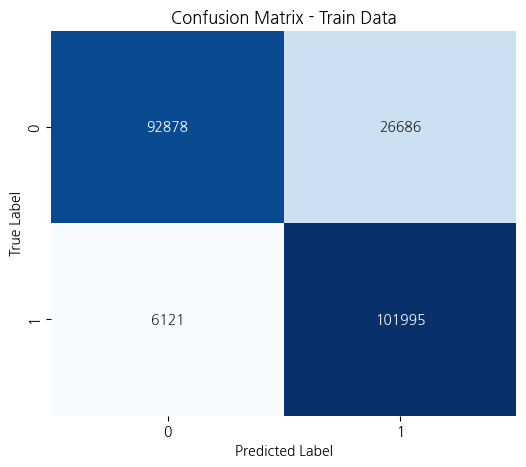

In [ ]:
# 훈련 세트에서의 혼동 행렬 계산 및 시각화
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm_train = confusion_matrix(y_train, y_train_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Train Data')
plt.show()

In [ ]:
# 테스트 세트에서 예측 수행
y_test_pred = ensemble_model.predict(X_test)

# 테스트 세트에서의 모델 성능 평가
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_classification_rep = classification_report(y_test, y_test_pred)

# 테스트 성능 출력
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print('\nTest Classification Report:\n', test_classification_rep)

Test Accuracy: 0.7563
Test F1 Score: 0.7647
Test Precision: 0.7009
Test Recall: 0.8413

Test Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.68      0.75     30126
           1       0.70      0.84      0.76     26794

    accuracy                           0.76     56920
   macro avg       0.76      0.76      0.76     56920
weighted avg       0.77      0.76      0.76     56920



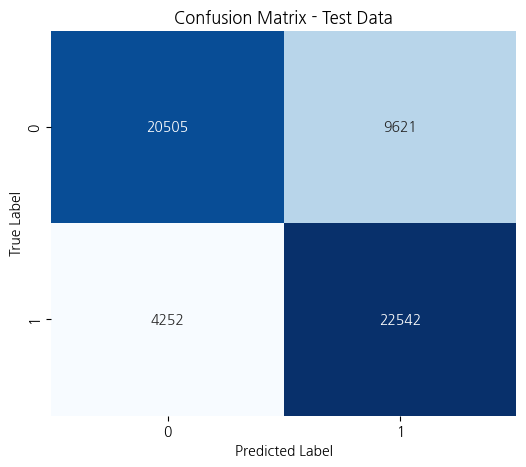

In [ ]:
# 테스트 세트에서의 예측 수행 및 혼동 행렬 계산
y_test_pred = ensemble_model.predict(X_test)
cm_test = confusion_matrix(y_test, y_test_pred)

# 테스트 세트에서의 혼동 행렬 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Test Data')
plt.show()

In [ ]:
# 최적의 하이퍼파라미터로 학습된 모델 저장
import joblib

model_filename = '/content/drive/MyDrive/KOPIS/블루스퀘어/best_ensemble_model.pkl'
joblib.dump(ensemble_model, model_filename)

print(f"모델이 '{model_filename}'에 저장되었습니다.")


모델이 '/content/drive/MyDrive/KOPIS/블루스퀘어/best_ensemble_model.pkl'에 저장되었습니다.
